# Semantics and Word vectors

A large part of the existing literature focuses on using the occurrence of specific words within a text corpus to perform downstream natural language processing tasks, from topic classification to cosine similarity and sentiment analysis. 

In this exercise, we show a simple instance of [word2vec](https://en.wikipedia.org/wiki/Word2vec), which can be used to extract intended meanings from complex phrases. The idea is to create numerical arrays, or *word embeddings* for every word in a large corpus. Each word is assigned its own vector in such a way that words that frequently appear together in the same context are given vectors that are close together. The result is a model that may not know what a "queen" is, but does know that "queen" is closer in context to "prince" than "queenfish".

It is important to note that *building* useful models takes a long time - hours or days to train a large corpus - and that for our purposes it is best to make use of a relatively small set of documents. An alternative is to import an existing model trained with word2vec - such as spaCy's large lexicons - which depending on the task or size of the data you want to process will be more efficient than training a model.

In [1]:
# Import packages
import os
import re
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
%matplotlib inline

#Sklearn
from sklearn.manifold import TSNE
from sklearn.cluster import KMeans

# Gensim
import gensim
from gensim.models import Word2Vec

# nltk
import nltk
from nltk.stem import SnowballStemmer
from nltk import sent_tokenize
from nltk.corpus import stopwords

# Shuffle
from random import shuffle

In [2]:
# Change your main directory accordingly
maindir = 'E:/Dropbox/Holder/practice/'
datadir = maindir + 'data/'

In this exercise we will use a relatively small corpus of New York Times articles collected between 1947 and 2010, with $n=4416$. These articles share in common the fact that in them is included at least one word associated to economic factors (growth, unemployment, inflation, etc.). Note that the dimension of this corpus is well below what a researcher would want to use to train a model. Let's first load the data and take a look at the first handful of entries.

In [3]:
# Read New York Times articles with economic keywords 
df = pd.read_csv(datadir + 'nyt_articles.csv')

<AxesSubplot:>

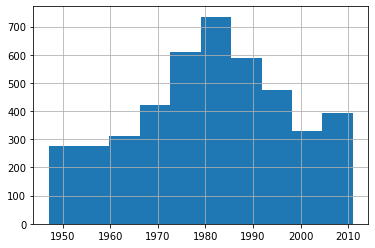

In [4]:
# Check time distribution of articles
df['date'] = pd.to_datetime(df['date'], format='%d/%m/%Y')

# Histogram plot
df['date'].hist()

In [5]:
# Check the first article, as well as a handful of entries
print(df['text'].iloc[0])
df.head()

Record backlogs and firm orders for durable goods, equipment, tool arid machinery lines now on hand point to 1947 prospects for stabilized production at a high level, with the major trend of increased productivity in evidence as assurance of a strong upward surge of this field of business.</br></br>.Many manufacturers of durable gOods, now quoting eight to twelve month delivery, have reported that orders have tended to increase as deliveries have increased, indicating that the arrival of a "buyer's market” may oc-c^p later than was generally expected by forecasters .The underlying post-war development which provides proof of the further bulwarking of the American economic scene, largely based upon "capital goods” invest-m,ents, is the further increase in</br></br>the investment of capital in heavy equipment to create both output and employment, as well as profits. While new machines, methods and processes installed and on order for early delivery, to accelerate this trend, are often un

,headline,date,text
0,"BIG YEAR EXPECTED IN HEAVY INDUSTRY: High, Sta...",1947-01-02,Record backlogs and firm orders for durable go...
1,STOCKS NEGOTIATE FRACTIONAL GAINS: Turnover Sl...,1947-01-15,Selective improvement invaded the stock market...
2,Stock Margins Cut to 75%; Eccles Sees Inflatio...,1947-01-18,Federal Reserve Head Reveals End of 100% Requi...
3,Some Alarming Portents for the Years After Arm...,1947-01-19,THE United States is proceeding- headlong towa...
4,JOB AGENCY CHECK IS ASKED BY CITY: BILL BEFORE...,1947-01-21,"ALBANY, Jan. 20—New York eity askedtonight -to..."



As in many other text analysis task, one can greatly improve the quality and performance of any model by clearing its input data. In particular, for our corpus of data we will 
- transform all upper case characters to **lower case** characters 
- remove any **punctuation** characters
- drop **stopwords**, words that appear frequently in texts but that add little to the training of any model
- optionally, we can also **stem** words, so that *economies* and *economy* are read as the same word given its root *econom*.

We will do so by pre-defining the functions we will pass our data through. This process is not exhaustive and many alternatives are plausible. For example, when only interested in word occurences one can build all pre-processing steps on sklearn's CountVectorizer directly. 

In [6]:
# Pre-processing steps
remove_punct = str.maketrans('','','!"#$%&\'()*+,-./:;<=>?@[\\]^_`{|}~“”’')
stop_words   = set(stopwords.words('english'))
stemmer      = SnowballStemmer('english')

In [7]:
# Pre-processing function
def normalize_text(doc):
    """Takes documents as input and outputs clean tokens"""
    
    doc        = doc.replace('</br>', ' ')
    lower      = doc.lower()                                             # all lower case
    nopunc     = lower.translate(remove_punct)                           # remove punctuation
    words      = nopunc.split()                                          # split into tokens
    nostop     = [w for w in words if w not in stop_words]               # remove stopwords
    no_numbers = [w if not w.isdigit() else '#' for w in nostop]         # normalize numbers
#     no_numbers    = [stemmer.stem(w) for w in no_numbers]                # stem each word
    
    return no_numbers

In [8]:
def get_sentences(doc):
    """Takes documents as input, splits it at the sentence level and passes the pre-processing function"""
    
    sent=[]
    
    for raw in sent_tokenize(doc):
        raw2 = normalize_text(raw)
        sent.append(raw2)
        
    return sent

In [9]:
# Create list to fill
sentences = []

for doc in df['text']:
    
    sentences += get_sentences(doc)     # Pre-processes each article's text
    
# Shuffles the list of split sentences - Necessary to compute stochastic gradient descent
shuffle(sentences)

Before moving on, let's have a quick look at what data we have produced. In the example sentence below, we can see lists of tokens corresponding to each sentence, which have had all 'nuisance' characters removed.

In [10]:
# First sentence
sentences[0]

['january',
 '#',
 'rate',
 '#',
 'percent',
 'based',
 'way',
 'things',
 'going',
 'dont',
 'think',
 'going',
 'juicy',
 'summer',
 'market',
 'said',
 'miriam',
 'ourin',
 'state',
 'labor',
 'department']

Note that so far there is nothing new about what we are doing. All the steps above are common to most count-based methods. They are also common to those models whose objective is to reduce dimensionality, like PCA or topic models. However, whereas these models use term-document or topic-document frequencies to map a vector of words to a lower-dimensional space, with *word embeddings* we aim at better understanding which words tend to appear under similar contexts.

# word2vec
A particular application of word embedding methods was popularized by [Mikolov et al 2013](https://arxiv.org/abs/1301.3781), which in particular propose two methods: CBOW and continuous skip-grams. Focusing on the latter, their idea was to train a model on a sliding window of words surrounding each word in your corpus, so that given any word the model would be able to predict its neighboring terms. This framework for learning word vectors can be largely summarized in a series of steps:
- Load in a large corpus of text
- Create a vector representation of every word in the corpus' vocabulary both as a center word $w_I$ and as a context word $w_o$
- Iterate through each position (word) in the text, look at the words comprised within the window
- Use the similarity of the context and center word vectors to compute a probability of a context word appearing given a center word
- Adjust these word vectors to increase the model's ability to predict context words

An example of the slidding window looks as follows:
<br>
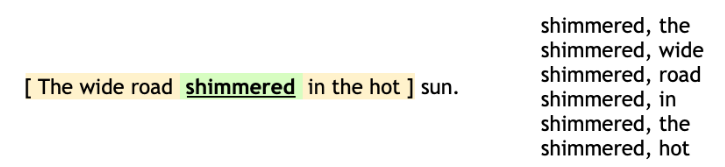
<br>
The key goal of the model is to learn the hidden layer that will map an input vector - a one-hot-representation of a center word - to a series of output vectors - the one-hot-representations of the context words. Graphically, a model that predicts the next word would thus look like this:
<div>
<img src="https://lilianweng.github.io/lil-log/assets/images/word2vec-skip-gram.png" alt="Drawing" style="width: 500px;"/><br>
</div>
The hidden layer corresponds to the $h$ vector, which is naught but the $W$ matrix row that corresponds to the input $x_i$ - here, the center word $w_I$. This vector can then be mapped to a one-hot vector after passing an output layer: this will be the *word* the model predicts, which above corresponds to $y_j$ - here, the context word $w_o$.

In the simplest specification of the model, the output layer is a softmax regression classifier, which transforms the dot-product of the hidden layer and the corresponding row in the output matrix and maps it to a probabilty distribution between 0 and 1. The training objective of the skip-gram model is thus to maximize the probability of predicting context words given the target word. For a sequence of words in T, the objective can be written (after taking logs):
<br>
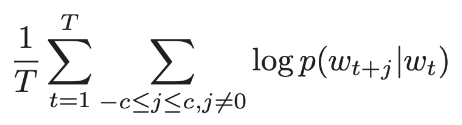
<br>
And, following the logic of the sliding window and the softmax classifier, the probability of a context word $w_o$ occuring given a center word $w_I$ is 
<br>
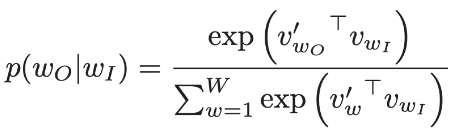
<br>
The dot-product multiplication of the hidden layer and the context-weights row in $W^{\prime}$ - which in the function corresponds to $v'_o$ - is done for each word and <context,word> pair. The probability that a word belongs with a set of context words is then obtained by passing the softmax classifier. Lastly, we apply stochastic gradient descent to update the values of the weights in the two layers (the hidden layer and the output or softmax layer) in case the machine didn't predict the word correctly and nudge our model closer to a local optimum. Graphically, the process looks as follows:
<br>
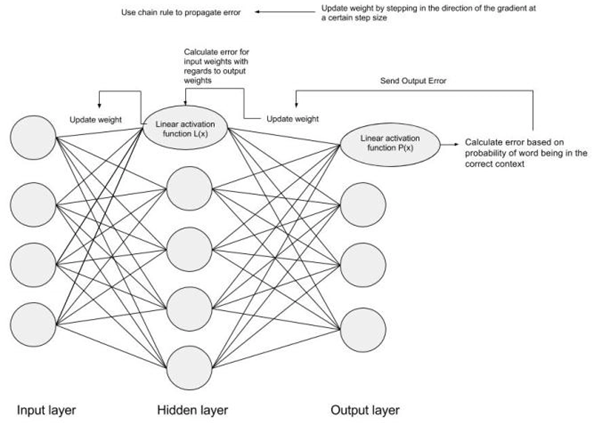
<br>
Note that when all is said and done, words that are used in similar situations will likely share similar neighboring words and the hidden vectors that will be built will thus be similar. At the core, this is the definition of similarity we obtain using word2vec: as first hinted above, the model will suggest the words "queen" and "prince" are similar since both are surrounded by regal terms. Conversely, the words "queenfish" and "queen" will be identified as holding little resemblance due to the fact that they are used in very different contexts. It follows that, mathematically, the hidden layer vectors of "queen" and "prince" will be similar but those of "queen" and "queenfish" will not. 

## Application
We will now implement the word2vec model to the corpus of New York Times articles we cleaned in the first section of the notebook. word2vec uses a single hidden layer, fully connected neural network, as shown in the graph above for the one-step-ahead prediction. The input consists of the list of tokenized sentences and the size of the input and output vectors is identical and corresponds to the corpus vocabulary $V$. The size of the hidden layer is a hyperparameter and as such is manually set. The same applies to the window size.

In [11]:
# Pass in the Word2Vec function from GENSIM package

w2v = Word2Vec(sentences,        # List of tokenized sentences
               workers   = 8,    # Number of threads to run in parallel
               size      = 300,   # Word vector dimensionality     
               min_count = 10,   # Minimum word count 
               window    = 5,    # Context window size (how far does w2v look at either side)     
               sample    = 0.75, # Downsample setting for frequent words - Mikolov et al chose 0.75, but this has been contested
               )

In [12]:
# Overwrites the raw, un-normed vectors
w2v.init_sims(replace=True)

# Save the data as a pickle
w2v.save('w2v-vectors.pkl')

<br>Let's first take a look at the size $V$ of our vocabulary. 

In [13]:
# Check for the length of V
word_vectors = w2v.wv
print('Size of the vocabulary:',len(word_vectors.vocab))

Size of the vocabulary: 6305


<br>Let's also investigate the hidden vector that corresponds to the word *economy*, $h_{economy}$

In [14]:
# Check the dense vector for the word economy
w2v.wv['economy']

array([-7.10189492e-02, -1.14986092e-01,  3.60074677e-02, -6.29707426e-02,
        4.63251723e-03, -4.48904373e-02,  5.28374948e-02, -1.37552440e-01,
        1.48666464e-02,  7.49384984e-02, -1.12177082e-03,  4.93127331e-02,
       -5.15086092e-02,  1.48515180e-02, -3.04754302e-02,  6.95243254e-02,
        7.18733221e-02,  4.03986871e-02,  2.89938785e-02,  7.82985389e-02,
       -4.85073542e-03, -1.52913824e-04,  2.58586165e-02, -9.78326052e-02,
        5.20272814e-02,  5.65570630e-02, -7.75556937e-02,  7.84302279e-02,
       -6.83249608e-02,  6.99773729e-02, -4.65031760e-03, -4.25348468e-02,
        3.12465914e-02, -1.14053860e-02, -6.82078153e-02, -4.43654619e-02,
       -1.88997556e-02, -3.25888544e-02, -2.93521304e-02,  8.44530016e-02,
        5.64629510e-02, -8.64400044e-02, -3.56791168e-02,  8.03797543e-02,
       -8.53866898e-03,  5.34095243e-02, -7.46891787e-03, -6.93785921e-02,
       -6.05810201e-03,  1.22316489e-02, -5.85012212e-02, -3.89050023e-04,
       -3.69640589e-02,  

<br>We can also check for how similar words are by computing the cosine similarity of words

In [15]:
# Similarity between two close synonyms (higher is more similar - dot product)
word_vectors.similarity('surge','rush')

0.70440024

In [16]:
# Similarity between two antonyms who likely share very similar contexts
word_vectors.similarity('surge','plunge')

0.8207654

<br>We can also look for words that are the most similar to any given word, and we can infer vectors by adding & subtracting related vectors

In [17]:
# Analogy: Economic prospects without growth may reflect __ (soviet, vietnam, doubts)
word_vectors.most_similar(positive=['economic','prospects'], negative=['growth'])

[('soviet', 0.7286500334739685),
 ('cited', 0.7068411707878113),
 ('described', 0.7051055431365967),
 ('talk', 0.7035738229751587),
 ('scientific', 0.6923491954803467),
 ('acknowledged', 0.6877678036689758),
 ('saying', 0.6815488338470459),
 ('doubts', 0.6802048087120056),
 ('words', 0.6766929626464844),
 ('grim', 0.6766642928123474)]

## Plot your word data
We can also plot our data by further reducing the hidden layer dimensions down to 2D or 3D. In order to do so, we use **t-SNE**, which is short for [t-Distributed Stochastic Neighbor Embedding](https://en.wikipedia.org/wiki/T-distributed_stochastic_neighbor_embedding). Although an explanation of the inner-workings of t-SNE is beyond the scope of this notebook, the main gist is that the algorithm models each high-dimensional object by a 2D or 3D point in a way that similar objects are modeled by points close together and different objects are modeled by points far apart with high probability. 

In [18]:
# List of word names
vocab = list(word_vectors.vocab)

# List of word vectors
X = word_vectors[vocab]

# 2D t-SNE
tsne = TSNE(n_components=2)

# As with most sklearn tools, "fit()" calculates the parameters of any technique whereas "transform()" applies it on data
X_tsne = tsne.fit_transform(X)
X_tsne.shape

(6305, 2)

<br>We can now visualize a handful of words using *matplotlib.pyplot*. Note how words are bunched together in ways that convey similarity in meaning and context.

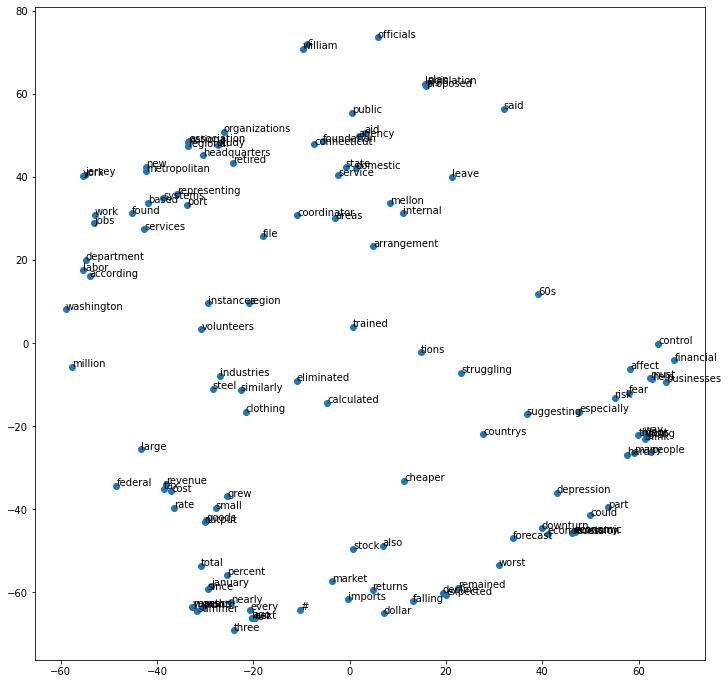

In [19]:

df2 = pd.DataFrame(X_tsne, index=vocab, columns=['x', 'y'])

fig = plt.figure(figsize=(12,12))
ax = fig.add_subplot(1, 1, 1)

ax.scatter(df2['x'][:125], df2['y'][:125])

for word, pos in df2.head(125).iterrows():
    ax.annotate(word, pos)

### K-means clustering and word2vec
In addition, we can cluster words given their vector similarities, which provides a more nuanced view of the different categories our data may comprise. 

In [20]:
# Define the K-means clustering object - and the number of clusters.
kmw = KMeans(n_clusters=30)

# Fit the K-means model to our w2v vectors
kmw.fit(word_vectors.vectors)

# We can check the words in the cluster of any word, say "economy"
word_clust = kmw.labels_[word_vectors.vocab['economy'].index]
print('Words in the cluster of economy:')
for i, cluster in enumerate(kmw.labels_):
    if cluster == word_clust and i<=100:
        print('     ',word_vectors.index2word[i])

Words in the cluster of economy:
      prices
      economy
      inflation
      may
      recession
      growth
      even
      much
      decline
      still


In [21]:
# The labels are mere number categories, but we could identify patterns and rename these
labels = kmw.labels_
print(labels)

[ 7 19  7 ...  4 21  9]


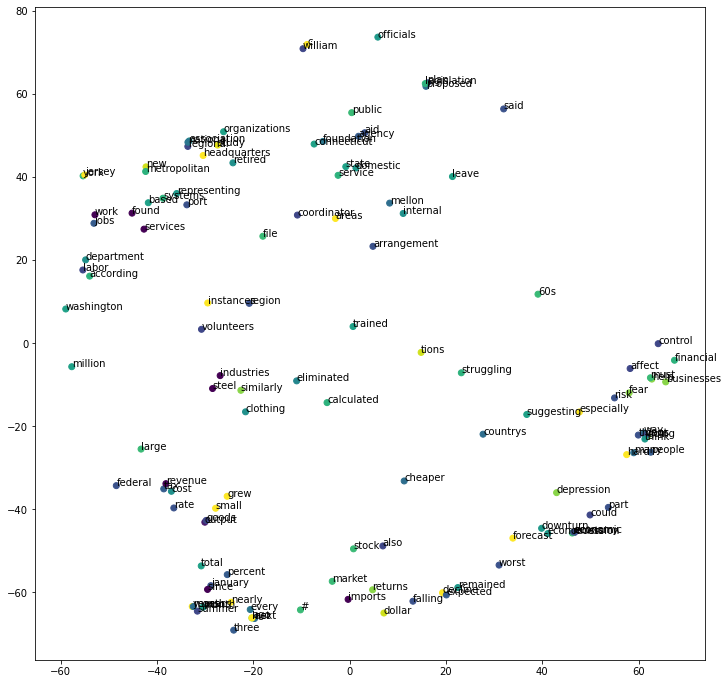

In [22]:
# Plot our words again using the t-SNE 2D vectors
fig = plt.figure(figsize=(12,12))
ax = fig.add_subplot(1, 1, 1)

ax.scatter(df2['x'][:125], df2['y'][:125], c=kmw.labels_[:125])

for word, pos in df2.head(125).iterrows():
    ax.annotate(word, pos)